**Análise de Custo de Plano de Saúde com Regressão Linear**

Este notebook apresenta a criação de um modelo de Regressão Linear para prever os custos de planos de saúde de pacientes com base em características pessoais.
O conjunto de dados utilizado contém informações demográficas e relacionadas à saúde, incluindo idade, sexo, índice de massa corporal (IMC), número de filhos,
se o paciente é fumante, região geográfica, entre outras. O objetivo do modelo é fornecer estimativas dos custos médicos anuais para auxiliar em políticas de precificação de seguros de saúde.
O dataset contém dados de pacientes adultos dos Estados Unidos e foi retirado do Kaggle a partir deste link: https://www.kaggle.com/datasets/teertha/ushealthinsurancedataset


### Carregamento dos Dados

Neste passo, carregamos o conjunto de dados e visualizamos as primeiras informações.


In [1]:
import pandas as pd

df = pd.read_csv('data/us-insurance-data.csv')


### Explorando o Conjunto de Dados

Visualizamos as principais características dos dados carregados, incluindo tipos de dados em cada coluna, estatísticas descritivas e verificações de valores ausentes.


### Exibindo informações e tipos de dados

In [2]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


None

### Resumo estatístico dos dados numéricos

In [3]:
display(df.describe())

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


### Tratamento de Valores Ausentes

Para garantir a integridade do dataset, realizamos o tratamento de valores ausentes.
Substituímos valores ausentes nas colunas numéricas pela **mediana** e removemos registros com valores ausentes nas colunas categóricas e na coluna `charges` (alvo de previsão),
pois esses não podem ser substituídos de maneira adequada.


In [4]:
from sklearn.impute import SimpleImputer

# Substituição de valores ausentes nas colunas numéricas com a mediana
numerical_cols = ['age', 'bmi', 'children']
numerical_imputer = SimpleImputer(strategy='median')
df[numerical_cols] = numerical_imputer.fit_transform(df[numerical_cols])

# Remoção de valores ausentes nas colunas categóricas e na coluna de custo (charges)
categorical_cols = ['sex', 'smoker', 'region']
df.dropna(subset=categorical_cols + ['charges'], inplace=True)


### Distribuição da Variável Alvo (`charges`)

Analisamos a distribuição da variável alvo `charges` através de um histograma. Esse passo é essencial para entender o comportamento dos custos médicos,
identificando assimetrias e possíveis valores atípicos que podem influenciar o desempenho do modelo.


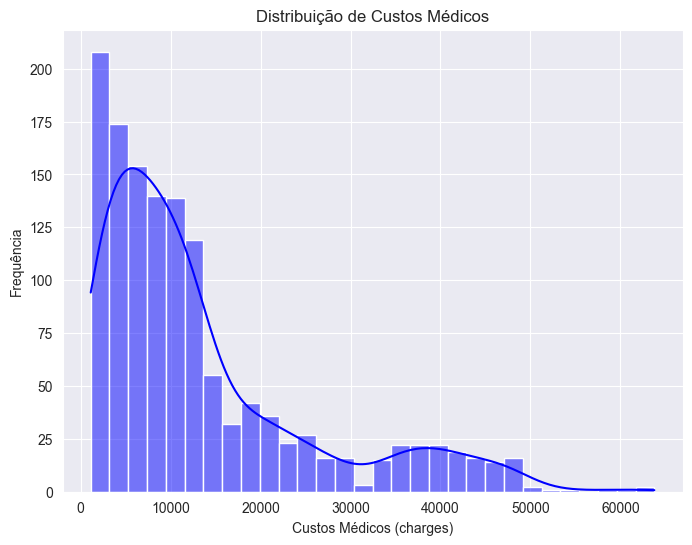

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.histplot(df['charges'], kde=True, color='blue')
plt.title('Distribuição de Custos Médicos')
plt.xlabel('Custos Médicos (charges)')
plt.ylabel('Frequência')
plt.show()


### Mapa de Correlação entre as Variáveis

Geramos um heatmap para identificar as correlações entre as variáveis do dataset.
Variáveis altamente correlacionadas com o alvo `charges` são de particular interesse, pois influenciam diretamente o modelo de regressão.


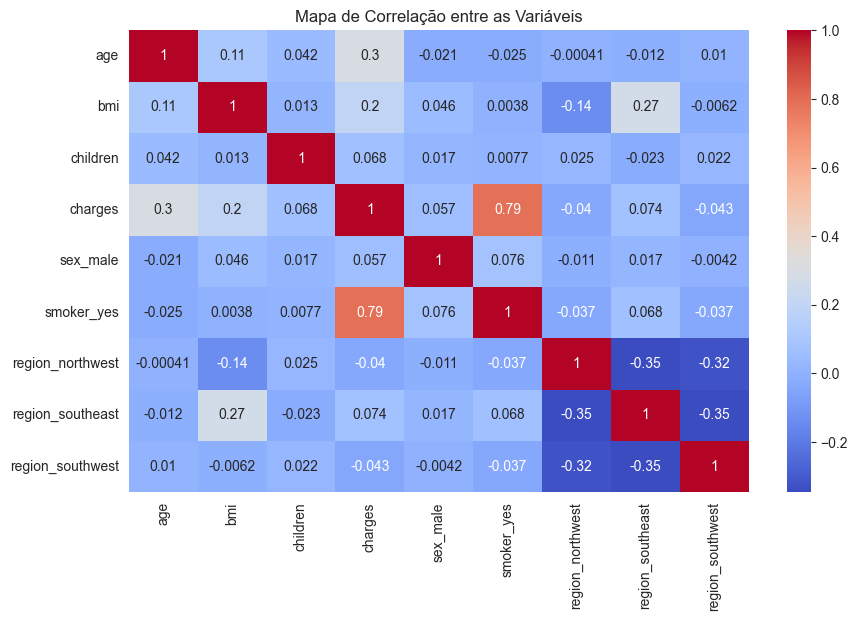

In [6]:
df_encoded = pd.get_dummies(df, drop_first=True)
plt.figure(figsize=(10,6))
sns.heatmap(df_encoded.corr(), annot=True, cmap='coolwarm')
plt.title('Mapa de Correlação entre as Variáveis')
plt.show()


### Comparação de Custos por Status de Fumante

O boxplot a seguir compara a distribuição dos custos médicos entre pacientes fumantes e não-fumantes.
Essa visualização ajuda a identificar como o hábito de fumar afeta os custos, uma variável que pode ter uma correlação significativa com o alvo `charges`.


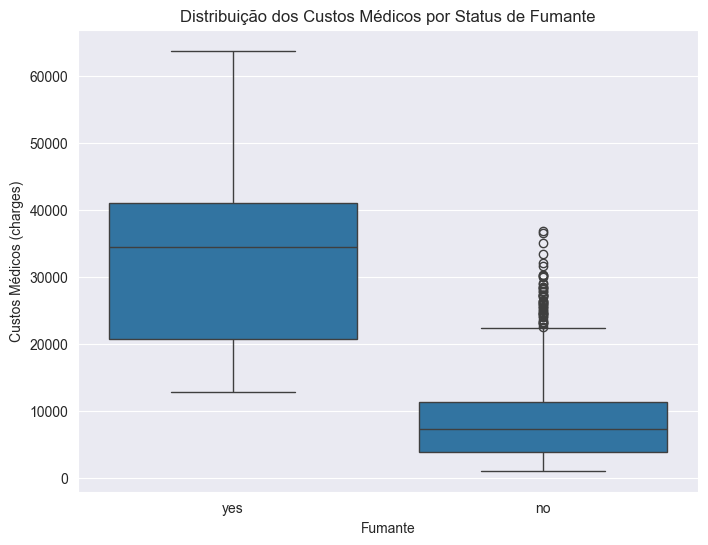

In [7]:
plt.figure(figsize=(8,6))
sns.boxplot(x='smoker', y='charges', data=df)
plt.title('Distribuição dos Custos Médicos por Status de Fumante')
plt.xlabel('Fumante')
plt.ylabel('Custos Médicos (charges)')
plt.show()


### Separando as variaveis de feature (X) e a variavel target (y)

In [8]:
# Fizemos alguns testes utilizando todas as colunas vs apenas as que tem maior correlacao com charges, e no final a diferenca nao se mostrou significativa.
X = df.drop('charges', axis=1)
y = df['charges']

### Pré-processamento: Transformação das Variáveis

Para preparar os dados para o modelo, aplicamos a padronização em variáveis numéricas e a codificação One-Hot em variáveis categóricas.
Essas transformações ajudam o modelo a processar as variáveis de forma eficiente.

In [9]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# Definição das variáveis numéricas e categóricas
categorical_cols = ['sex', 'smoker', 'region']
numerical_cols = ['age', 'bmi', 'children']

# Aplicando OneHotEncoder e StandardScaler nas variaveis categoricas e numericas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(), categorical_cols)
    ])
X_preprocessed = preprocessor.fit_transform(X)

### Separação dos Dados em Treino e Teste

Dividimos o dataset em conjuntos de treino e teste, com 80% dos dados para o treinamento do modelo e 20% para avaliação.
Essa divisão permite avaliar a capacidade de generalização do modelo em dados novos.


In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_preprocessed, y, test_size=0.2, random_state=42)


### Construindo o Modelo de Regressão Linear

Neste passo, criamos e treinamos um modelo de Regressão Linear simples. Esse modelo será avaliado com base em sua capacidade de prever os custos médicos no conjunto de teste.


In [11]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


### Avaliação do Modelo com Métricas de Desempenho

Calculamos métricas de avaliação como **Erro Médio Absoluto (MAE)**, **Erro Quadrático Médio (MSE)**, **Raiz do Erro Quadrático Médio (RMSE)** e **Coeficiente de Determinação (R²)** para entender o desempenho do modelo.


In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r_squared = r2_score(y_test, y_pred)

print('\nMétricas de Avaliação do Modelo:')
print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
print(f'R2 Score: {r_squared:.4f}')



Métricas de Avaliação do Modelo:
Mean Absolute Error (MAE): 4176.96
Mean Squared Error (MSE): 33568529.30
Root Mean Squared Error (RMSE): 5793.84
R2 Score: 0.7838


### Cross Validation com 5-Folds

Utilizamos a validação cruzada com 5-folds para avaliar a estabilidade do modelo.
Isso fornece uma estimativa mais robusta do desempenho do modelo em diferentes subconjuntos dos dados.


In [13]:
from sklearn.model_selection import cross_val_score, KFold

# Aplicamos um random_state para garantir que os resultados do cross-validation sejam reproduzíveis
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results = cross_val_score(model, X_preprocessed, y, cv=kfold)
print(f"K-Fold (R²) Scores: {cv_results}")
print(f"Média do R²: {cv_results.mean():.2f}")
print(f"Desvio Padrão do R²: {cv_results.std():.2f}")
# Nota-se que os valores medios e o desvio padrao mostram que o modelo possui uma variancia baixa, isto é, o modelo está generalizando bem os dados de treino.


K-Fold (R²) Scores: [0.78359298 0.7380458  0.79558615 0.63243806 0.75131533]
Média do R²: 0.74
Desvio Padrão do R²: 0.06


### Comparação: Valores Reais vs. Valores Preditos

O gráfico abaixo mostra a relação entre os valores reais e os valores preditos pelo modelo. Uma linha vermelha indica o ideal, onde os valores previstos seriam iguais aos valores reais.


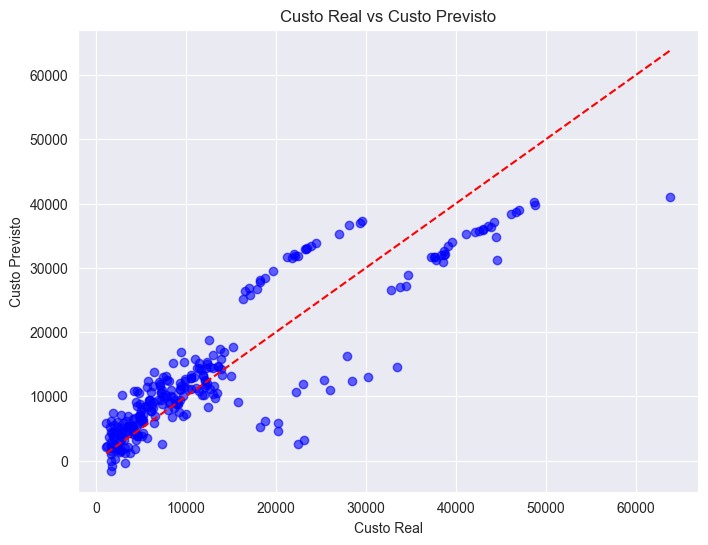

In [14]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Custo Real')
plt.ylabel('Custo Previsto')
plt.title('Custo Real vs Custo Previsto')
plt.show()

# Nota-se que a maioria dos pontos segue a linha vermelha, indicando que o modelo esta conseguindo capturar a tendencia geral dos dados. Isso significa que, para muitos casos, as previsões estão razoavelmente próximas dos valores reais, especialmente para valores mais baixos.

# Para valores de custos mais baixos, o modelo parece ser mais preciso, com a maioria dos pontos próximos da linha vermelha. No entanto, conforme os valores de custos aumentam, o modelo tende a subestimar os custos reais. Vários pontos estão bem abaixo da linha para valores de custos altos, indicando que o modelo tem dificuldade em prever com precisão os valores mais altos.

# Existem alguns pontos que estão significativamente distantes da linha vermelha, indicando outliers ou casos onde o modelo falhou em prever corretamente. Esses outliers podem estar associados a características específicas dos dados (como a presença de fumantes ou indivíduos com condições de saúde específicas) que não foram capturadas corretamente pelo modelo

# A discrepância entre os valores reais e previstos para os custos mais altos sugere que o modelo linear pode não estar capturando toda a complexidade da relação entre as variáveis de entrada e o custo de saúde. Um modelo mais complexo (como uma árvores de decisão) pode ser mais eficaz para esses casos.


## Conclusão

- O modelo de Regressão Linear apresenta boa capacidade para prever custos médicos em valores baixos e médios, mas apresenta limitações para valores altos.
- Os resultados sugerem que modelos mais complexos podem ser explorados para melhor capturar a variabilidade nos valores mais altos.
- A estabilidade do modelo nos diferentes folds (cross-validation) mostra que ele generaliza bem, mas com espaço para otimização.